In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import clip
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pandas as pd
import pickle as pkl
import numpy as np 
import xgboost as xgb
import warnings

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

PyTorch version: 2.5.1
CUDA available: False
CUDA version: None


In [2]:
X_train = pd.read_csv('../X_train.csv')
X_test = pd.read_csv('../X_test.csv')
y_train = pd.read_csv('../y_train.csv')
y_test = pd.read_csv('../y_test.csv')
X_train_resnet = pd.read_csv('../X_train_resnet.csv', header=None).astype(float)
X_test_resnet = pd.read_csv('../X_test_resnet.csv', header=None).astype(float)

X_val = pd.read_csv('../X_val.csv')
y_val = pd.read_csv('../y_val.csv')
X_val_resnet = pd.read_csv('../X_val_resnet.csv', header=None).astype(float)


In [ ]:
import xgboost as xgb
import matplotlib.pyplot as plt
from IPython.display import clear_output

class XgBoost(nn.Module):
    def __init__(self):
        super(XgBoost, self).__init__()
        self.xgb = xgb.XGBRegressor(
            n_estimators=2000, 
            max_depth=5, 
            learning_rate=0.08, 
            objective='reg:squarederror'
        )
    
    def forward(self, x):
        return self.xgb.predict(x)
    
    def fit(self, X, y, X_val=None, y_val=None, verbose=True, early_stopping_rounds=50):
        """
        Entrena el modelo XGBoost con la opción de monitorear el progreso en un conjunto de validación,
        usando early stopping y visualizando la pérdida de entrenamiento y validación en tiempo real.
        """
        if X_val is not None and y_val is not None:
            eval_set = [(X, y), (X_val, y_val)]  # Entrenamiento y validación
            eval_metric = ["rmse"]
            self.xgb.fit(X, y, eval_set=eval_set, eval_metric=eval_metric, 
                         early_stopping_rounds=early_stopping_rounds, verbose=False)
            
            # Guardamos los resultados de la pérdida en cada iteración
            results = self.xgb.evals_result()
            self.plot_loss_curve_real_time(results)
        else:
            self.xgb.fit(X, y, verbose=verbose)

    def plot_loss_curve_real_time(self, results):
        """
        Grafica la curva de pérdida de entrenamiento y validación en tiempo real.
        """
        epochs = len(results['validation_0']['rmse'])
        x_axis = range(0, epochs)

        # Inicializar el gráfico
        plt.ion()  # Activar el modo interactivo
        fig, ax = plt.subplots(figsize=(10, 6))
        train_loss_line, = ax.plot([], [], label='Train Loss', color='blue')
        val_loss_line, = ax.plot([], [], label='Validation Loss', color='orange')
        ax.set_xlim(0, epochs)
        ax.set_ylim(0, max(min(results['validation_0']['rmse']), min(results['validation_1']['rmse'])) + 0.1)
        ax.set_xlabel('Epochs')
        ax.set_ylabel('RMSE')
        ax.set_title('Real-Time Training and Validation Loss')
        ax.legend()
        ax.grid(True)

        # Actualizar el gráfico en tiempo real
        for epoch in range(epochs):
            train_loss = results['validation_0']['rmse'][:epoch+1]
            val_loss = results['validation_1']['rmse'][:epoch+1]
            
            train_loss_line.set_data(x_axis[:epoch+1], train_loss)
            val_loss_line.set_data(x_axis[:epoch+1], val_loss)
            
            # Limpiar y redibujar
            clear_output(wait=True)
            plt.draw()
            plt.pause(0.1)

        plt.ioff()  # Desactivar el modo interactivo
        plt.show()


In [4]:
import pandas as pd
import numpy as np

def generate_random_feature_combinations(X_train, X_test,X_val, num_features, random_state=None):
    """
    Randomly combines pairs of columns with random operations (including powers) to create new features,
    ensuring consistency between X_train and X_test.
    
    Parameters:
    - X_train: pd.DataFrame, the training dataset.
    - X_test: pd.DataFrame, the test dataset.
    - num_features: int, the number of new features to generate.
    - random_state: int, seed for reproducibility (default: None).
    
    Returns:
    - X_train_new: pd.DataFrame, training dataset with new features added.
    - X_test_new: pd.DataFrame, test dataset with new features added.
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    X_train_new = X_train.copy()
    X_test_new = X_test.copy()
    X_val_new = X_val.copy()

    columns = X_train.columns
    selected_pairs = []
    
    operations = ['*', '/']
    powers = ['^2', '^3', '^0.5', '^1.5'] 
    
    # Generate random column pairs and operations
    for _ in range(num_features):
        col1, col2 = np.random.choice(columns, 2, replace=False)
        operation = np.random.choice(operations + powers)
        selected_pairs.append((col1, col2, operation))
    
    # Apply the same pairs and operations to both X_train and X_test
    for col1, col2, operation in selected_pairs:
        new_feature_name = f"{col1}_{operation}_{col2}"
        

        if operation == '-':
            X_train_new[new_feature_name] = X_train_new[col1] - X_train_new[col2]
            X_test_new[new_feature_name] = X_test_new[col1] - X_test_new[col2]
            X_val_new[new_feature_name] = X_val_new[col1] - X_val_new[col2]

        elif operation == '/':
            # Avoid division by zero using np.where
            X_train_new[new_feature_name] = np.where(X_train_new[col2] != 0, 
                                                      X_train_new[col1] / X_train_new[col2], 
                                                      np.nan)
            X_test_new[new_feature_name] = np.where(X_test_new[col2] != 0, 
                                                     X_test_new[col1] / X_test_new[col2], 
                                                     np.nan)
            X_val_new[new_feature_name] = np.where(X_val_new[col2] != 0,
                                                    X_val_new[col1] / X_val_new[col2],
                                                    np.nan)
        elif operation == '^2':  # Square of the first column
            X_train_new[new_feature_name] = X_train_new[col1] ** 2
            X_test_new[new_feature_name] = X_test_new[col1] ** 2
            X_val_new[new_feature_name] = X_val_new[col1] ** 2
        elif operation == '^3':  # Cube of the first column
            X_train_new[new_feature_name] = X_train_new[col1] ** 3
            X_test_new[new_feature_name] = X_test_new[col1] ** 3
            X_val_new[new_feature_name] = X_val_new[col1] ** 3
        elif operation == '^0.5':  # Square root of the first column
            X_train_new[new_feature_name] = np.sqrt(X_train_new[col1])
            X_test_new[new_feature_name] = np.sqrt(X_test_new[col1])
            X_val_new[new_feature_name] = np.sqrt(X_val_new[col1])
    
    return X_train_new, X_test_new, X_val_new

# Example usage
warnings.filterwarnings("ignore")
X_train_new, X_test_new, X_val_new = generate_random_feature_combinations(X_train, X_test, X_val, num_features=2000, random_state=42)

print(X_train_new.head())
print(X_test_new.head())


   photo_count  ispro  Animal  Electronics  Entertainment  Family  Fashion  \
0       6658.0    0.0     0.0          0.0            1.0     0.0      0.0   
1       1113.0    0.0     0.0          0.0            0.0     0.0      0.0   
2       1290.0    0.0     0.0          0.0            0.0     0.0      1.0   
3       5532.0    1.0     0.0          0.0            0.0     0.0      1.0   
4       7082.0    1.0     0.0          0.0            0.0     0.0      0.0   

   Food  Holiday&Celebrations  Social&People  ...  perspective_/_Gymnastics  \
0   0.0                   0.0            0.0  ...                       NaN   
1   0.0                   0.0            0.0  ...                       NaN   
2   0.0                   0.0            0.0  ...                       NaN   
3   0.0                   0.0            0.0  ...                       NaN   
4   0.0                   0.0            0.0  ...                       NaN   

   Gymnastics_^3_repeat  Travel_/_gettingready  weekday_

In [5]:
X_train_combined = pd.concat([X_train_resnet[:50], X_train_new], axis=1)
X_test_combined = pd.concat([X_test_resnet[:50], X_test_new], axis=1)
X_val_combined = pd.concat([X_val_resnet[:50], X_val_new], axis=1)


#add columns names X_train_resnet and X_val_resnet
X_train_resnet.columns = [f'col_{i}' for i in range(X_train_resnet.shape[1])]
X_test_resnet.columns = [f'col_{i}' for i in range(X_test_resnet.shape[1])]
X_val_resnet.columns = [f'col_{i}' for i in range(X_val_resnet.shape[1])]


In [6]:
#reduce dimencionality of vecotrs with pca
from sklearn.decomposition import PCA
pca = PCA(n_components=200)
X_train_combined = pca.fit_transform(X_train_resnet)
X_test_combined = pca.transform(X_test_resnet)
X_val_combined = pca.transform(X_val_resnet)

X_train_combined = pd.DataFrame(X_train_combined)
X_test_combined = pd.DataFrame(X_test_combined)
X_val_combined = pd.DataFrame(X_val_combined)

X_train_combined.columns = [f'col_{i}' for i in range(X_train_combined.shape[1])]
X_test_combined.columns = [f'col_{i}' for i in range(X_test_combined.shape[1])]
X_val_combined.columns = [f'col_{i}' for i in range(X_val_combined.shape[1])]



In [7]:
model = XgBoost()
model.fit(X_train_new, y_train, X_val_new, y_val, verbose=True)
y_pred2 = model(X_test_new)


TypeError: XGBModel.fit() got an unexpected keyword argument 'eval_metric'

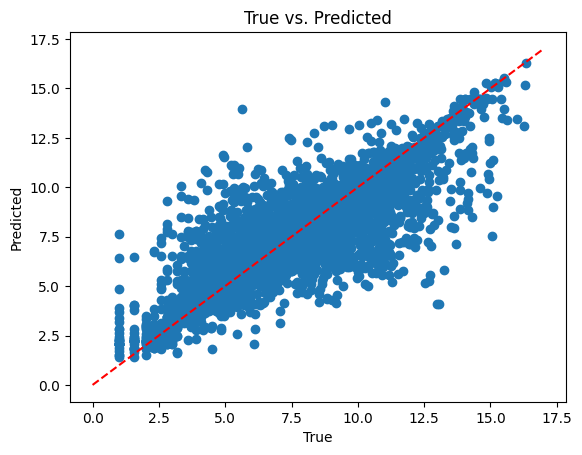

In [ ]:
# model1 = XgBoost()
# model1.fit(X_train_resnet*100, y_train[1:], X_val=X_val_resnet*100, y_val=y_val[1:], verbose=True)
# y_pred1 = model1(X_test_resnet*100)

# y_pred = (y_pred1 + y_pred2) / 2

# plt.plot(y_test, y_pred, 'o')
# plt.xlabel('True')
# plt.ylabel('Predicted')
# plt.title('True vs. Predicted')

plt.plot(y_test, y_pred2, 'o')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('True vs. Predicted')
plt.plot([0, 17], [0, 17], 'r--')
